In [1]:
import sys
sys.path.insert(0,'C:\\Users\\Syahrir Ridha\\PycharmProjects\\NET_Solver\\')
import numpy as np
import pandas as pd
import torch
from geometry import *
from utils import Plot_Grid
from utils import *
from hard_boundary import *
from solver import *
from models import *
from mesh import *
from boundary import *
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None 
%matplotlib inline

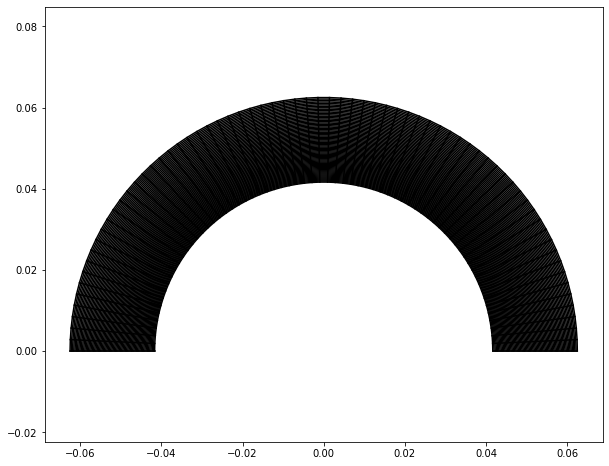

In [229]:
# mesh data
# pre processing Mesh data
nx, ny = 70,70
r_out = 0.75*0.0833333
r_in =  0.5*0.0833333
e = 0.
h =0.01
grid = EllipticGrid(r_out, r_in, e,nx,ny,h)()
Plot_Grid(grid['x'], grid['y'],nx, ny)

In [282]:
tau = 0#0.009*0.007
n = 0.56
k = (1.74/100)*0.007
dpdz = 0.5

class Governing_Eq(Transform_PDE):
    def PDELoss(self, inputs, outputs, derivatives):
        # calculate the computational derivataes
        #print(derivatives[:5])
        dxdxi, dxdeta, dydxi, dydeta = self.seperate_data(derivatives)
        alpha, beta, gamma, det = self.compute_data(derivatives)
        
        #print(dxdxi)
        
        # calculate the gradients
        out_grad = self.compute_grad(outputs, inputs)
        du_dxi, du_deta = out_grad[:,0], out_grad[:,1]
        
        # calculate viscoity
        vis = self.HB_model(dxdxi, dxdeta, dydxi, dydeta, det, du_dxi, du_deta, n, k, tau)
        
        # code the left part
        left = (vis/det)*(alpha*du_dxi - gamma*du_deta)
        
        right = (vis/det)*(beta*du_deta - gamma*du_dxi)
        
        # derivative of left and right
        left_xi = self.compute_grad(left, inputs)[:,0]
        
        right_eta = self.compute_grad(right, inputs)[:,1]
        
        # combine evverything
        gov_eq = (left_xi + right_eta) + dpdz*det
        
        return {'PDE': gov_eq}
    
    def HB_model(self, dxdxi, dxdeta, dydxi, dydeta, det, du_dxi, du_deta, n, k, tau, cs=0.1 ):
        
        # calculate the shear 
        shear = self.shear_rate(dxdxi, dxdeta, dydxi, dydeta, det, du_dxi, du_deta)
        
        # create a dummy vicosity
        vis = torch.zeros_like(shear)
        
        # mask the shear rate less than the crtial shear rate
        # mask for the body portion
        mask_body = shear>cs
        # mask for the boundary portion
        mask_bound = shear<= cs
        
        # create index for the body and boundary mask
        ind_body = torch.nonzero(mask_body).unsqueeze(1)
        ind_bound = torch.nonzero(mask_bound).unsqueeze(1)
        
        # calculate the modified apparent viscsity
        vis[ind_body] = (tau)/shear[ind_body] + ((shear[ind_body])**(n-1))*k
        #vis[ind_bound] = tau*(2 - (shear[ind_bound]/cs))/cs + k * ( (2-n)+(n-1)* (shear[ind_bound]/cs))
        vis[ind_bound] = (2/cs) + (2-n)*k
        #vis[ind_bound] = tau/cs + k*cs**(n-1)
        
        return vis
#     def HB_model(self, dxdxi, dxdeta, dydxi, dydeta, det, du_dxi, du_deta, n, k, tau):
#         shear = self.shear_rate(dxdxi, dxdeta, dydxi, dydeta, det, du_dxi, du_deta)
#         #print(shear.reshape(nx,ny))
#         app_vis = (tau/shear) + (shear**(n-1))*k
#         return (app_vis)
        
    
    def shear_rate(self, dxdxi, dxdeta, dydxi, dydeta, det, du_dxi, du_deta, tol=1e-5):
        
        # calculate shear rate
        shear_ = torch.sqrt((1/det)**2*((dydeta*(du_dxi) - dydxi*(du_deta))**2 + (dxdxi*(du_deta) - dxdeta*(du_dxi))**2))
        
        #create mask
        dummy_shear = torch.zeros_like(shear_)
        mask = (shear_ <=tol)
        indices = torch.nonzero(mask).unsqueeze(1)
        dummy_shear[indices] = tol
        shear = torch.sqrt((1/det)**2*((dydeta*(du_dxi+dummy_shear) - dydxi*(du_deta+dummy_shear))**2 + (dxdxi*(du_deta+dummy_shear) - dxdeta*(du_dxi+dummy_shear))**2))
        shear_.data[mask] = tol
        
        return torch.abs(shear_)
        
    
    def compute_data(self, computation):
        dxdxi, dxdeta, dydxi, dydeta = self.seperate_data(computation)
        alpha = dxdeta**2 + dydeta**2
        beta = dxdxi**2 + dydxi**2
        gamma = dxdxi*dxdeta + dydeta*dydxi
        det = dxdxi*dydeta - dxdeta*dydxi
        return alpha, beta, gamma, det
    
    def seperate_data(self,computation):
        dxdxi = computation[:,0]
        dxdeta = computation[:,1]
        dydxi = computation[:,2]
        dydeta = computation[:,3]
        return dxdxi, dxdeta, dydxi, dydeta
    
# initiate the PDE equation
pde = Governing_Eq(inputs=('xi', 'eta'),derivative = ('dxdxi', 'dxdeta', 'dydxi', 'dydeta','jac_inv'), outputs='u')

pass


In [283]:
mesh = Mesh_Data({'xi':grid['xi'], 'eta':grid['eta']},
                {'dxdxi':grid['dx_dxi'], 'dxdeta':grid['dx_deta'], 
                'dydxi':grid['dy_dxi'], 'dydeta':grid['dy_deta'],'jac_inv':grid['jac_inv']})

In [284]:
pde.set_mesh(mesh)

In [285]:
mesh.gen_data[:][0]

tensor([[0.0000, 0.0000],
        [0.0100, 0.0000],
        [0.0200, 0.0000],
        ...,
        [0.6700, 0.6900],
        [0.6800, 0.6900],
        [0.6900, 0.6900]])

In [286]:
def _init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        y = m.in_features
        m.weight.data.normal_(0.0, 1. / np.sqrt(y))
        m.bias.data.fill_(0)
class Trial_Solution:
    def __init__(self, model, boundary):
        self.model = model
        self.model.apply(_init_weights)
        self.var = tuple(boundary.keys())
        self.bound = list(boundary.values())
        
    def __call__(self,input_data):
        #x = input_data[:,0].reshape(-1,1)
        trial = (input_data[:,0].reshape(-1,1) )*(0.69-input_data[:,0].reshape(-1,1))*self.model(input_data)
        return abs(trial)

In [287]:
# when dudxi = 0 @ eta = 0,1
eta_ = np.array([0,.69])
class Neumann(Neumann):
    def neumann_loss(self, inputs, outputs):
        dudeta = self.compute_grad(outputs, inputs)[:,1]
        return {'gradXi': dudeta}
outer = Neumann({'xi':eta_, 'eta':grid['eta']}, name='left_flank')
pde.add_boundary(outer)

In [288]:
btach_size = 1000
lr = 0.0001
epochs = 1000
hid_dim = 50
layers = 7
in_dim = len(pde.input)
out_dim = len(pde.output)
activation = Sine()
#activation = torch.nn.ReLU()

net = MLP(in_dim, out_dim, layers, hid_dim, act=activation)
trial = Trial_Solution(net, {'xi_inn':0.0, 'xi_out':1.0})
#net.apply(_init_weights)

optimizer = torch.optim.Adam(net.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = lr, pct_start=0.1, total_steps=epochs)

pde.compile(trial,optimizer, scheduler)

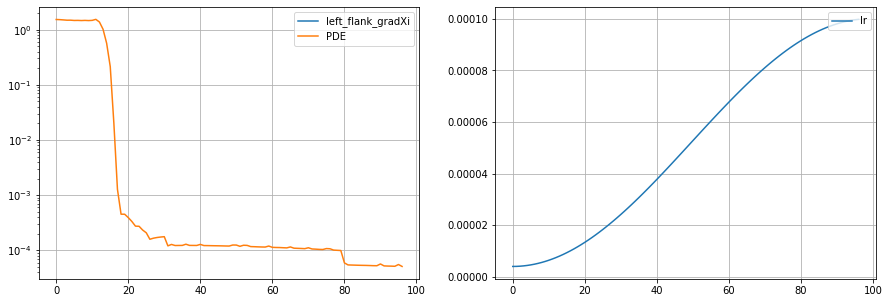

KeyboardInterrupt: 

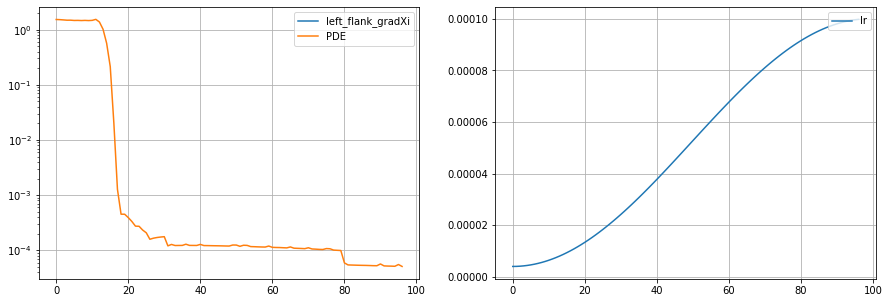

In [289]:
%time hist = pde.solve(epochs, btach_size)

In [290]:
x = np.linspace(0,.69,nx)
y = np.linspace(0,0.69,ny)

eval_mesh = Mesh({'x':x, 'y':y})
#pred = pde.eval(eval_mesh).view(len(y),len(x)).numpy()
pred = trial(eval_mesh.gen_data[:]).view(len(y),len(x)).detach().numpy()

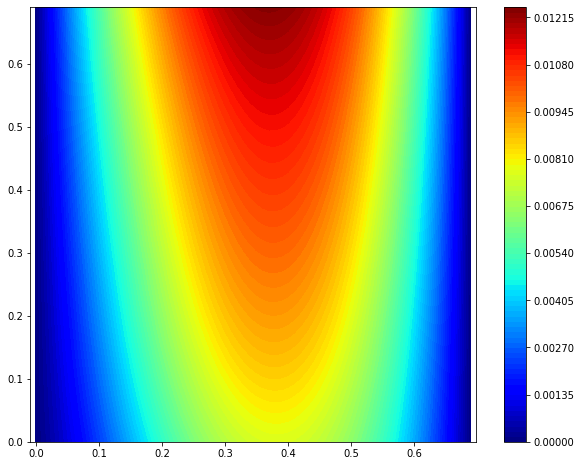

In [291]:
plt.figure(figsize=(10,8))
xx, yy = np.meshgrid(x,y)
plt.contourf(xx,yy, pred, 100, cmap='jet')
plt.colorbar()
plt.axis('equal');

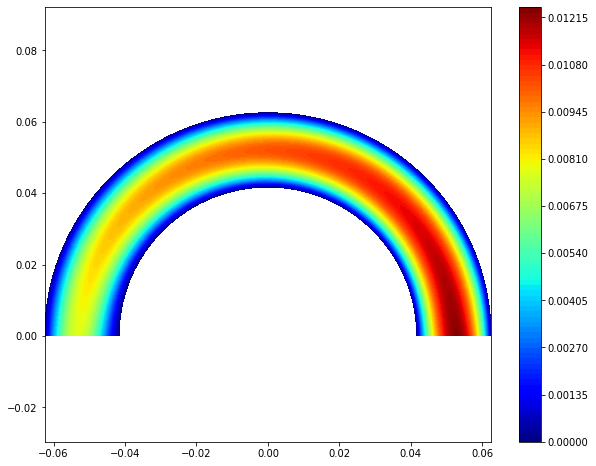

In [292]:
plt.figure(figsize=(10,8))
#grid = TFI(xi, eta, annulus)()
plt.contourf(grid['x'].reshape(nx,ny),grid['y'].reshape(nx,ny), (pred).T, 100, cmap='jet')
plt.colorbar()
plt.axis('equal');

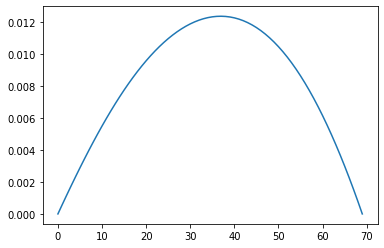

In [293]:
plt.plot(pred[-1,:])

In [295]:
from scipy.integrate import simps
simps([simps(zz_x,x) for zz_x in abs(pred)],y) *2*448.831

2.787100205682224

In [255]:
(0.00101**2/(1000**(0.48)*0.017526**(0.48+2)))**(1/(2-0.48))

0.00947369355337595

In [160]:
4.3/0.00947369355337595

453.88844126879064

In [161]:
grid['jac']

array([[0.00572795, 0.00527456, 0.00505868, ..., 0.00505868, 0.00527456,
        0.00572795],
       [0.00576851, 0.00534308, 0.00512304, ..., 0.00512304, 0.00534308,
        0.00576851],
       [0.00580928, 0.00540873, 0.00518679, ..., 0.00518679, 0.00540873,
        0.00580928],
       ...,
       [0.00850748, 0.0090738 , 0.00941989, ..., 0.00941989, 0.0090738 ,
        0.00850748],
       [0.00854962, 0.00916264, 0.00951956, ..., 0.00951956, 0.00916264,
        0.00854962],
       [0.00859193, 0.00925649, 0.00962227, ..., 0.00962227, 0.00925649,
        0.00859193]])